## Setup and Imports

In [ ]:
!nvidia-smi

Tue Oct 22 15:12:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install -Uq git+https://github.com/huggingface/diffusers@main
!pip install -Uq git+https://github.com/huggingface/transformers@main
!pip install -Uq bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 8.6 MB/s eta 0:00:00


In [ ]:
from transformers import T5EncoderModel
from diffusers import (
    CogVideoXPipeline,
    CogVideoXTransformer3DModel,
    AutoencoderKLCogVideoX,
)
from diffusers.video_processor import VideoProcessor
from diffusers.utils import export_to_gif
from IPython.display import Image
import torch
import gc

## Utility to reset VRAM

In [ ]:
def flush():
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.reset_peak_memory_stats()

## Encoding the prompt

In [ ]:
model_id = "ariG23498/CogVideoX-5b-nf4-pkg"

In [ ]:
flush()
gc.collect()

/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:343: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


30

In [ ]:
text_encoder = T5EncoderModel.from_pretrained(
    model_id,
    subfolder="text_encoder",
    device_map="cpu",
)

text_encoder/config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


model.safetensors:   0%|          | 0.00/6.33G [00:00<?, ?B/s]

In [ ]:
pipe = CogVideoXPipeline.from_pretrained(
    "THUDM/CogVideoX-5b",
    transformer=None,
    vae=None,
    text_encoder=text_encoder,
    torch_dtype=torch.float16,
)

pipe.enable_model_cpu_offload()

model_index.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer/added_tokens.json:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
prompt = """\
A panda, dressed in a small, red jacket and a tiny hat, sits on a wooden stool \
in a serene bamboo forest. The panda's fluffy paws strum a miniature acoustic \
guitar, producing soft, melodic tunes. Nearby, a few other pandas gather, watching \
curiously and some clapping in rhythm. Sunlight filters through the tall bamboo, \
casting a gentle glow on the scene. The panda's face is expressive, showing \
concentration and joy as it plays. The background includes a small, flowing \
stream and vibrant green foliage, enhancing the peaceful and magical atmosphere \
of this unique musical performance.\
"""

with torch.no_grad():
    print("Encoding prompts.")
    prompt_embeds, negative_prompt_embeds = pipe.encode_prompt(
        prompt=prompt,
    )

Encoding prompts.


In [ ]:
pipe.to("cpu")

del text_encoder
del pipe

flush()
gc.collect()

9641

## Compute latents

In [ ]:
transformer = CogVideoXTransformer3DModel.from_pretrained(model_id, subfolder="transformer")

transformer/config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.14G [00:00<?, ?B/s]

In [ ]:
pipe = CogVideoXPipeline.from_pretrained(
    "THUDM/CogVideoX-5b",
    transformer=transformer,
    vae=None,
    text_encoder=None,
    tokenizer=None,
    torch_dtype=torch.float16,
)
pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
with torch.no_grad():
    latents = pipe(
        prompt_embeds=prompt_embeds,
        negative_prompt_embeds=negative_prompt_embeds,
        guidance_scale=6,
        num_inference_steps=50,
        num_frames=16,
        output_type="latent",
    )

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
pipe.to("cpu")

del transformer
del pipe

flush()
gc.collect()

68

## Decode latents

In [ ]:
vae = AutoencoderKLCogVideoX.from_pretrained(model_id, subfolder="vae")
vae.enable_tiling()
vae.enable_slicing()

vae/config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

You are loading your model in 8bit or 4bit but no linear modules were found in your model. Please double check your model architecture, or submit an issue on github if you think this is a bug.


In [ ]:
latents = latents.frames

latents = latents.permute(0, 2, 1, 3, 4)  # [batch_size, num_channels, num_frames, height, width]
latents = 1 / vae.config.scaling_factor * latents

with torch.no_grad():
    frames = vae.decode(latents).sample

In [ ]:
vae_scale_factor_spatial = 2 ** (len(vae.config.block_out_channels) - 1)

video_processor = VideoProcessor(vae_scale_factor=vae_scale_factor_spatial)
video = video_processor.postprocess_video(video=frames, output_type="pil")

export_to_gif(video[0], "panda.gif")

'panda.gif'

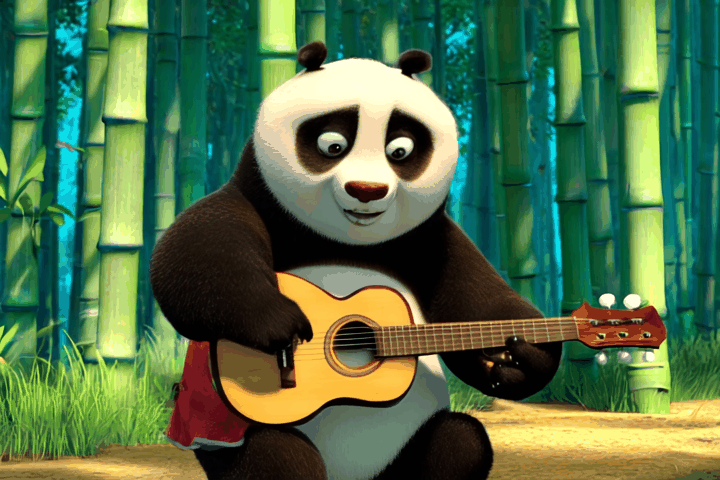

In [ ]:
Image(open('/content/panda.gif','rb').read())